In [3]:
import os
import cv2
import numpy as np
import glob
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#Paths for datasets
base_dataset_path = '/kaggle/input/deforestation-in-ukraine/'
development_dataset_path = '/kaggle/working/processed_dataset/'

# **Preprocess and save images in a new directory**

In [5]:
def preprocess_and_save_images(base_dataset_path, dev_dataset_path, target_size=(256, 256)):
    
    if not os.path.exists(dev_dataset_path):
        os.makedirs(dev_dataset_path)

    #Itirate through all subfolders and convert all .jp2 images
    for folder in os.listdir(base_dataset_path):
        img_data_path = os.path.join(base_dataset_path, folder, "*.SAFE/GRANULE/*/IMG_DATA/*_TCI.jp2")
        tci_image_files = glob.glob(img_data_path)
        
        for image_file in tci_image_files:
            subdirectory_name = image_file.split('/')[-3]
            dest_subdirectory_path = os.path.join(dev_dataset_path, subdirectory_name)
            
            if not os.path.exists(dest_subdirectory_path):
                os.makedirs(dest_subdirectory_path)

            # Load and preprocess image
            preprocessed_image = load_and_preprocess_image(image_file, target_size)
            dest_image_path = os.path.join(dest_subdirectory_path, os.path.basename(image_file).replace('.jp2', '.jpg'))
            
            cv2.imwrite(dest_image_path, preprocessed_image)

def load_and_preprocess_image(image_path, target_size=(256, 256)):
    
    print(f"Loading image: {image_path}")
    
    #Load .jp2 image from main directory dataset
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        print(f"Error: Could not load image {image_path}")
        return None
    
    # Resize image to target size
    img_resized = cv2.resize(img, target_size)            #Resize to U-Net input size(256x256)
    img_rescaled = (img_resized / np.max(img_resized) * 255).astype(np.uint8)       #Normalize and convert to 8-bit
    return img_rescaled

In [6]:
#Start preprocessing on base dataset
preprocess_and_save_images(base_dataset_path, development_dataset_path)

Loading image: /kaggle/input/deforestation-in-ukraine/S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510/S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510.SAFE/GRANULE/L1C_T36UYA_A003350_20160212T084510/IMG_DATA/T36UYA_20160212T084052_TCI.jp2
Loading image: /kaggle/input/deforestation-in-ukraine/S2A_MSIL1C_20160621T084012_N0204_R064_T36UYA_20160621T084513/S2A_MSIL1C_20160621T084012_N0204_R064_T36UYA_20160621T084513.SAFE/GRANULE/L1C_T36UYA_A005209_20160621T084513/IMG_DATA/T36UYA_20160621T084012_TCI.jp2
Loading image: /kaggle/input/deforestation-in-ukraine/S2A_MSIL1C_20190606T083601_N0207_R064_T36UXA_20190606T104250/S2A_MSIL1C_20190606T083601_N0207_R064_T36UXA_20190606T104250.SAFE/GRANULE/L1C_T36UXA_A020653_20190606T083602/IMG_DATA/T36UXA_20190606T083601_TCI.jp2
Loading image: /kaggle/input/deforestation-in-ukraine/S2B_MSIL1C_20190313T083739_N0207_R064_T36UYA_20190313T122406/S2B_MSIL1C_20190313T083739_N0207_R064_T36UYA_20190313T122406.SAFE/GRANULE/L1C_T36UYA_A010529_

# **Initialization of U-Net model and preprocessing images to fit the model**

In [151]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
#         self.enc1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)   #For RGB approach
        self.enc1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.enc4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = nn.ReLU()(self.enc1(x))
        x = self.pool(x)
        x = nn.ReLU()(self.enc2(x))
        x = self.pool(x)
        x = nn.ReLU()(self.enc3(x))
        x = self.pool(x)
        x = nn.ReLU()(self.enc4(x))
        return x                      #Extracted features

model = UNet()
model.eval()

#Preprocess and transform images for U-Net input
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [151]:
def load_and_preprocess_image_for_model(image_path, target_size=(256, 256), device='cpu'):

    img = Image.open(image_path).convert('L')        #Convert to grayscale using PIL library ('L' mode)

    #Preprocess image: resize, convert to tensor, normalize
    preprocess = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])       #Single channel normalization (grayscale)
    ])
    
    img_tensor = preprocess(img).unsqueeze(0)      #Add batch dimension
    return img_tensor.to(device)

In [187]:
#Function to extract features from images using U-Net
def extract_features(image_path, model):
    image_tensor = load_and_preprocess_image_for_model(image_path)
    with torch.no_grad():
        #Extract features from the bottleneck layer of U-Net
        features = model(image_tensor)
    return features.squeeze(0).cpu().numpy()        #Convert to numpy array

def compare_features(features1, features2):
    
    #Flatten the features and compute cosine similarity
    features1_flat = features1.reshape(1, -1)
    features2_flat = features2.reshape(1, -1)
    similarity = cosine_similarity(features1_flat, features2_flat)[0][0]
    return similarity

# **Function to find pairs of similar images based on features**

In [187]:
def find_similar_images(dev_dataset_path, model, threshold=0.90):            #Threshold is so high to allow more accurate comparison
    image_files = glob.glob(os.path.join(dev_dataset_path, '**', '*.jpg'), recursive=True)
    similar_pairs = []
    
    #Dictionary to keep track of comparisons
    compared_pairs = set()
    matches_found = 0
    total_comparisons = 0

    for i, image_file1 in enumerate(image_files):
        features1 = extract_features(image_file1, model)
        for j in range(i + 1, len(image_files)):
            image_file2 = image_files[j]

            # Ensure unique comparisons (no repeated pairs or self-comparisons)
            if (image_file1, image_file2) in compared_pairs or (image_file2, image_file1) in compared_pairs:
                continue
            
            total_comparisons += 1
            
            features2 = extract_features(image_file2, model)
            similarity = compare_features(features1, features2)

            if similarity > threshold:
                similar_pairs.append((image_file1, image_file2))
                compared_pairs.add((image_file1, image_file2))         #Mark comparison as done
                matches_found += 1
                print(f"Matched: {image_file1} and {image_file2} with similarity: {similarity:.2f}")

    print(f"Total number of matches found: {matches_found}")
    print(f"Total number of comparisons made: {total_comparisons}")    
    
    return similar_pairs

In [188]:
#Output similiar images paths
matched_images = find_similar_images(development_dataset_path, model)

Matched: /kaggle/working/processed_dataset/L1C_T36UYA_A020939_20190626T083926/T36UYA_20190626T083601_TCI.jpg and /kaggle/working/processed_dataset/L1C_T36UXA_A007526_20180815T084148/T36UXA_20180815T084009_TCI.jpg with similarity: 0.91
Matched: /kaggle/working/processed_dataset/L1C_T36UYA_A020939_20190626T083926/T36UYA_20190626T083601_TCI.jpg and /kaggle/working/processed_dataset/L1C_T36UYA_A019938_20190417T083603/T36UYA_20190417T083601_TCI.jpg with similarity: 0.95
Matched: /kaggle/working/processed_dataset/L1C_T36UYA_A020939_20190626T083926/T36UYA_20190626T083601_TCI.jpg and /kaggle/working/processed_dataset/L1C_T36UXA_A016363_20180810T084438/T36UXA_20180810T083601_TCI.jpg with similarity: 0.99
Matched: /kaggle/working/processed_dataset/L1C_T36UYA_A020939_20190626T083926/T36UYA_20190626T083601_TCI.jpg and /kaggle/working/processed_dataset/L1C_T36UYA_A004022_20160330T082810/T36UYA_20160330T082542_TCI.jpg with similarity: 0.96
Matched: /kaggle/working/processed_dataset/L1C_T36UYA_A02093

Total number of matches found: 435
Total number of comparisons made: 1225

In [189]:
matched_images

[('/kaggle/working/processed_dataset/L1C_T36UYA_A020939_20190626T083926/T36UYA_20190626T083601_TCI.jpg',
  '/kaggle/working/processed_dataset/L1C_T36UXA_A007526_20180815T084148/T36UXA_20180815T084009_TCI.jpg'),
 ('/kaggle/working/processed_dataset/L1C_T36UYA_A020939_20190626T083926/T36UYA_20190626T083601_TCI.jpg',
  '/kaggle/working/processed_dataset/L1C_T36UYA_A019938_20190417T083603/T36UYA_20190417T083601_TCI.jpg'),
 ('/kaggle/working/processed_dataset/L1C_T36UYA_A020939_20190626T083926/T36UYA_20190626T083601_TCI.jpg',
  '/kaggle/working/processed_dataset/L1C_T36UXA_A016363_20180810T084438/T36UXA_20180810T083601_TCI.jpg'),
 ('/kaggle/working/processed_dataset/L1C_T36UYA_A020939_20190626T083926/T36UYA_20190626T083601_TCI.jpg',
  '/kaggle/working/processed_dataset/L1C_T36UYA_A004022_20160330T082810/T36UYA_20160330T082542_TCI.jpg'),
 ('/kaggle/working/processed_dataset/L1C_T36UYA_A020939_20190626T083926/T36UYA_20190626T083601_TCI.jpg',
  '/kaggle/working/processed_dataset/L1C_T36UYA_A01

# **Visualize images for visual comparison(matched or unmatched)**

In [192]:
def load_and_display_images(image_path1, image_path2):

    img1 = cv2.imread(image_path1)
    img2 = cv2.imread(image_path2)

    #Convert images to RGB
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    #Display images side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(img1)
    ax1.set_title('Image 1')
    ax1.axis('off')

    ax2.imshow(img2)
    ax2.set_title('Image 2')
    ax2.axis('off')

    plt.show()

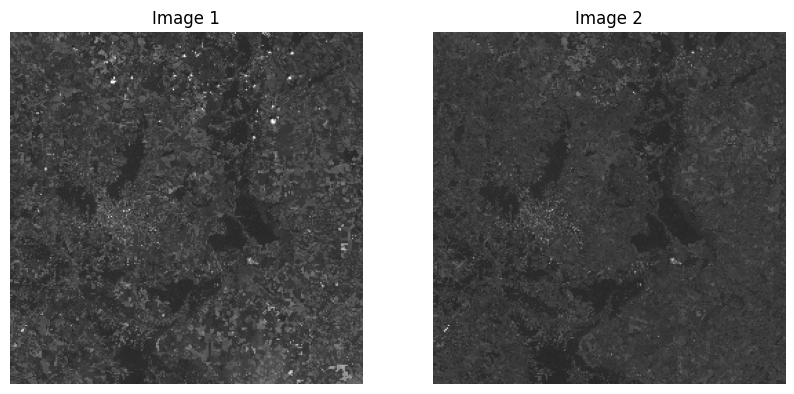

In [195]:
#Display matched images
image_path1 = '/kaggle/working/processed_dataset/L1C_T36UYA_A020939_20190626T083926/T36UYA_20190626T083601_TCI.jpg'
image_path2 = '/kaggle/working/processed_dataset/L1C_T36UYA_A006210_20160830T083600/T36UYA_20160830T083602_TCI.jpg'
load_and_display_images(image_path1, image_path2)

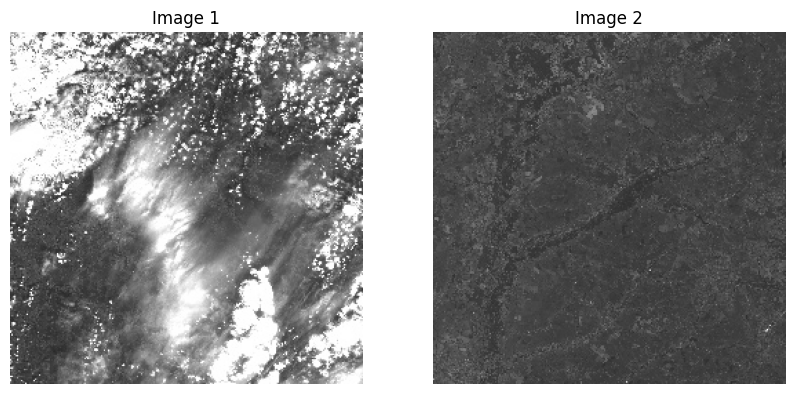

In [198]:
#Display unmatched images
image_path1 = '/kaggle/working/processed_dataset/L1C_T36UYA_A019652_20190328T084013/T36UYA_20190328T084011_TCI.jpg'
image_path2 = '/kaggle/working/processed_dataset/L1C_T36UXA_A020081_20190427T083603/T36UXA_20190427T083601_TCI.jpg'
load_and_display_images(image_path1, image_path2)

#                                      **Visualizing matched areas between two images using ORB algorithm**

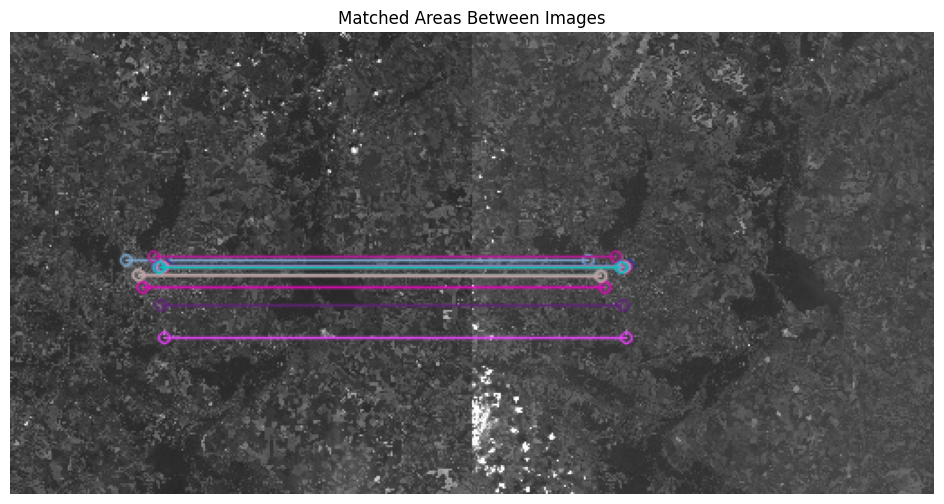

In [183]:
def draw_orb_matches(image_path1, image_path2, max_lines=15):
    img1 = cv2.imread(image_path1, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image_path2, cv2.IMREAD_GRAYSCALE)

    orb = cv2.ORB_create()

    #detect ORB keypoints and their descriptors
    keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

    #Match descriptors using BFMatcher with Hamming distance
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)

    #Sort matched based on distance
    matches = sorted(matches, key=lambda x: x.distance)

    matches = matches[:max_lines]    #Select the top 'max_lines' matches

    #Draw matches on the images
    img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Step 8: Display the matches
    plt.figure(figsize=(12, 6))
    plt.imshow(img_matches, cmap='gray')
    plt.title("Matched Areas Between Images")
    plt.axis('off')
    plt.show()


# image_path1 = '/kaggle/working/processed_dataset/L1C_T36UYA_A021082_20190706T083605/T36UYA_20190706T083611_TCI.jpg'
# image_path2 = '/kaggle/working/processed_dataset/L1C_T36UYA_A021797_20190825T083616/T36UYA_20190825T083601_TCI.jpg'

#You can test drawing matches for one of the matched pairs or by inputing path manually
image_path1, image_path2 = matched_images[10]
draw_orb_matches(image_path1, image_path2, max_lines=15)


# **Attempts to visualize feature matches between two images using U-Net model (did not work)**

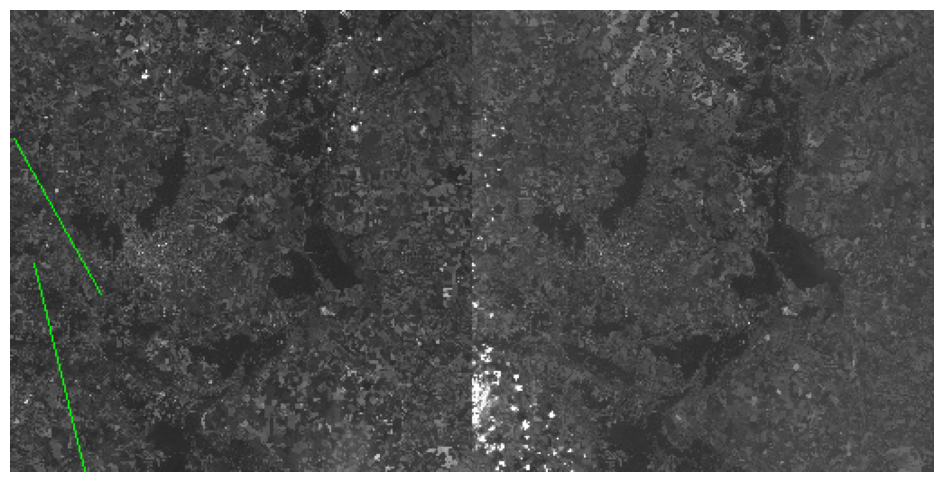

In [205]:
def draw_unets_matches(image_path1, image_path2, model, max_lines=4):

    def compute_dense_matches(features1, features2):

        #matches: list of matched indices
        #size1, size2: dimensions of the two feature maps
        
        height, width = features1.shape[:2]
        total_pixels = height * width

        #random matches for illustration
        matches = np.random.randint(0, total_pixels, total_pixels)
        return matches, (height, width), (height, width)

    features1 = extract_features(image_path1, model)
    features2 = extract_features(image_path2, model)

    matches, (height1, width1), (height2, width2) = compute_dense_matches(features1, features2)

    img1 = cv2.imread(image_path1)
    img2 = cv2.imread(image_path2)
    
    img1_resized = cv2.resize(img1, (256, 256))
    img2_resized = cv2.resize(img2, (256, 256))

    #Combining images side by side
    img_combined = np.hstack((img1_resized, img2_resized))

    total_pixels = height1 * width1
    selected_indices = np.random.choice(total_pixels, min(max_lines, total_pixels), replace=False)

    for i in selected_indices:
        #2D coordinates for the current pixel in image 1
        y1, x1 = divmod(i, width1)

        #Matched index in the second image
        match_idx = matches[i]
        y2, x2 = divmod(match_idx, width2)
        x2 += width1

        color = (0, 255, 0)
        cv2.line(img_combined, (x1, y1), (x2, y2), color, 1)

    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(img_combined, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

image_path1, image_path2 = matched_images[10]
draw_unets_matches(image_path1, image_path2, model)

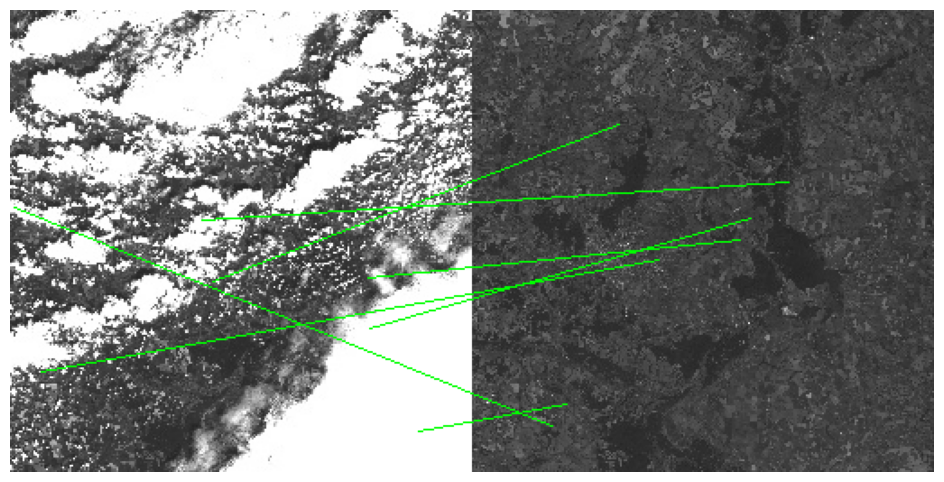

In [89]:
image_path1 = '/kaggle/working/processed_dataset/L1C_T36UYA_A021082_20190706T083605/T36UYA_20190706T083611_TCI.jpg'
image_path2 = '/kaggle/working/processed_dataset/L1C_T36UYA_A021797_20190825T083616/T36UYA_20190825T083601_TCI.jpg'

draw_unets_matches(image_path1, image_path2, model, max_lines=7)

In [134]:
def preprocess_image_pytorch(image_path, target_size, device):
    """
    Preprocess the input image to feed into the PyTorch U-Net model.
    Resizes the image to the target_size, normalizes it, and converts it to a tensor.
    """
    img = Image.open(image_path).convert("RGB")
    preprocess = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img_tensor = preprocess(img).unsqueeze(0)
    return img_tensor.to(device)               #Move tensor to the appropriate device

def extract_features_unet_pytorch(model, image_path, target_size=(128, 128), device='cpu'):
    preprocessed_img = preprocess_image_pytorch(image_path, target_size, device)
    
    with torch.no_grad():
        feature_map = model(preprocessed_img)
    return feature_map.cpu().numpy()          #Convert back to numpy array for further processing

def match_features(feature_map1, feature_map2):
    
    feature_map1 = feature_map1.reshape(-1, feature_map1.shape[-1])
    feature_map2 = feature_map2.reshape(-1, feature_map2.shape[-1])
    
    similarity_matrix = cosine_similarity(feature_map1, feature_map2)
    
    match_indices = np.unravel_index(np.argsort(similarity_matrix.ravel())[-50:], similarity_matrix.shape)
    
    return match_indices

def draw_accurate_matches(image_path1, image_path2, model, target_size=(128, 128), device='cpu', max_lines=7):

    feature_map1 = extract_features_unet_pytorch(model, image_path1, target_size, device)
    feature_map2 = extract_features_unet_pytorch(model, image_path2, target_size, device)

    matched_indices = match_features(feature_map1, feature_map2)

    img1 = cv2.imread(image_path1)
    img2 = cv2.imread(image_path2)

    img1 = cv2.resize(img1, target_size)
    img2 = cv2.resize(img2, target_size)

    img_matches = np.hstack((img1, img2))         #Concatenate images horizontally
    
    for idx1, idx2 in zip(matched_indices[0], matched_indices[1]):
        pt1 = (idx1 % target_size[1], idx1 // target_size[1])
        pt2 = (idx2 % target_size[1] + target_size[1], idx2 // target_size[1])        #Adjust for concatenation
        color = tuple(np.random.randint(0, 255, 3).tolist())
        cv2.line(img_matches, pt1, pt2, color, 1)

    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
    plt.title("Matched Areas Between Images")
    plt.show()

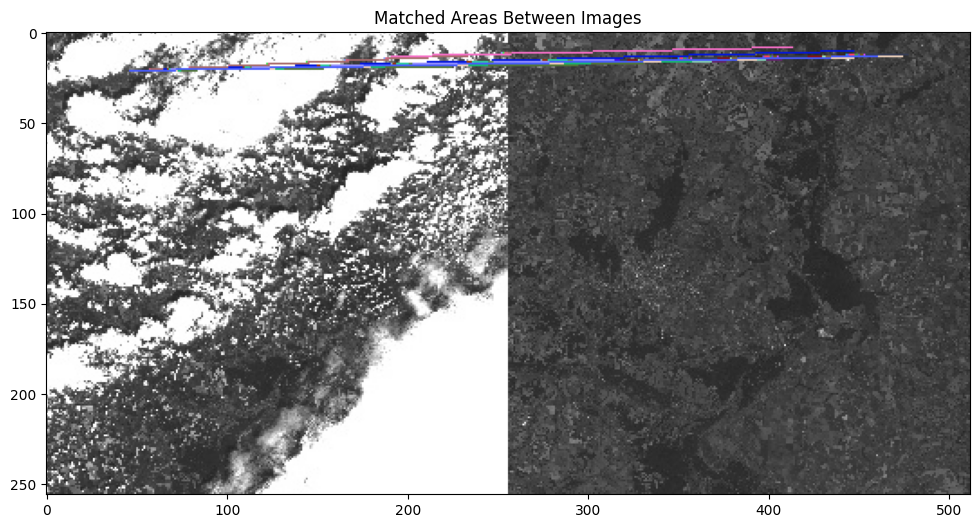

In [134]:
# Example usage
image_path1 = '/kaggle/working/processed_dataset/L1C_T36UYA_A021082_20190706T083605/T36UYA_20190706T083611_TCI.jpg'
image_path2 = '/kaggle/working/processed_dataset/L1C_T36UYA_A021797_20190825T083616/T36UYA_20190825T083601_TCI.jpg'


draw_accurate_matches(image_path1, image_path2, model, target_size=(256, 256))